In [1]:
# %matplotlib inline 可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd

In [2]:
from sklearn.datasets.california_housing import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)

downloading Cal. housing from http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz to C:\Users\user\scikit_learn_data
California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




In [5]:
housing.data.shape

(20640, 8)

In [6]:
housing.data[0]

array([   8.3252    ,   41.        ,    6.98412698,    1.02380952,
        322.        ,    2.55555556,   37.88      , -122.23      ])

In [7]:
from sklearn import tree
dtr = tree.DecisionTreeRegressor(max_depth = 2)
# .fit表示构造决策树 
# 里面传入两个值分别是 x值和y值 x是数据 y是最终的结果值
dtr.fit(housing.data[:, [6, 7]], housing.target)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [8]:
#要可视化显示 首先需要安装 graphviz   http://www.graphviz.org/Download..php
dot_data = \
    tree.export_graphviz(
        dtr,
        out_file = None,
        feature_names = housing.feature_names[6:8],
        filled = True,
        impurity = False,
        rounded = True
    )

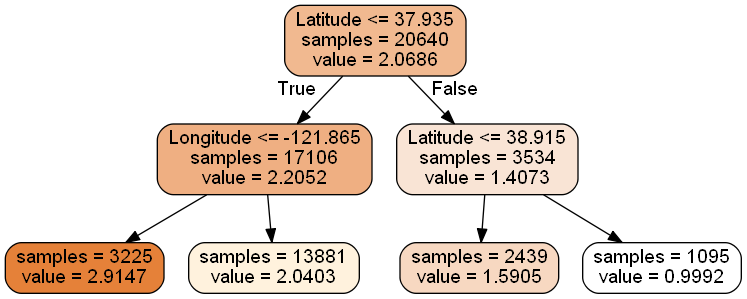

In [10]:
#pip install pydotplus
import pydotplus
graph = pydotplus.graph_from_dot_data(dot_data)
graph.get_nodes()[7].set_fillcolor("#FFF2DD")
from IPython.display import Image
Image(graph.create_png())

In [11]:
graph.write_png("dtr_white_background.png")

True

In [13]:
from sklearn.model_selection import train_test_split
# 切分数据集，切分为训练集和测试集 
# housing.data为 x 训练值
# housing.target为 y 训练结果
# test_size = 0.1 ，选取10%为测试集
# random_state 随机种子 很多模型都需要一个随机的设定（比如迭代的初始值等等）。random_state的作用就是固定这个随机设定，---------
# --因为sklearn中很多算法都含有随机的因素，为了进行可重复的训练，我需要固定一个random_state。
调参的时候，这个random_state通常是固定好不变的。
data_train, data_test, target_train, target_test = \
    train_test_split(housing.data, housing.target, test_size = 0.1, random_state = 42)
dtr = tree.DecisionTreeRegressor(random_state = 42)
dtr.fit(data_train, target_train)
dtr.score(data_test, target_test)

0.637318351331017

In [23]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor( random_state = 42)
rfr.fit(data_train, target_train)
rfr.score(data_test, target_test)

0.79086492280964926

## 树模型参数:

-  1.criterion  gini  or  entropy

-  2.splitter  best or random 前者是在所有特征中找最好的切分点 后者是在部分特征中（数据量大的时候）

-  常用：3.max_features  None（所有），log2，sqrt，N  特征小于50的时候一般使用所有的

-  常用：4.max_depth  数据少或者特征少的时候可以不管这个值，如果模型样本量多，特征也多的情况下，可以尝试限制下

-  5.min_samples_split  如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。是为了防止过拟合

-  6.min_samples_leaf  这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝，如果样本量不大，不需要管这个值，大些如10W可是尝试下5

-  7.min_weight_fraction_leaf 这个值限制了叶子节点所有样本权重和的最小值，如果小于这个值，则会和兄弟节点一起被剪枝默认是0，就是不考虑权重问题。一般来说，如果我们有较多样本有缺失值，或者分类树样本的分布类别偏差很大，就会引入样本权重，这时我们就要注意这个值了。

-  8.max_leaf_nodes 通过限制最大叶子节点数，可以防止过拟合，默认是"None”，即不限制最大的叶子节点数。如果加了限制，算法会建立在最大叶子节点数内最优的决策树。如果特征不多，可以不考虑这个值，但是如果特征分成多的话，可以加以限制具体的值可以通过交叉验证得到。

-  9.class_weight 指定样本各类别的的权重，主要是为了防止训练集某些类别的样本过多导致训练的决策树过于偏向这些类别。这里可以自己指定各个样本的权重如果使用“balanced”，则算法会自己计算权重，样本量少的类别所对应的样本权重会高。

- 10.min_impurity_split 这个值限制了决策树的增长，如果某节点的不纯度(基尼系数，信息增益，均方差，绝对差)小于这个阈值则该节点不再生成子节点。即为叶子节点 。
- n_estimators:要建立树的个数

In [24]:
from sklearn.grid_search import GridSearchCV
# GridSearchCV 它存在的意义就是自动调参，只要把参数输进去，就能给出最优化的结果和参数。但是这个方法适合于小数据集，
tree_param_grid = { 'min_samples_split': list((3,6,9)),'n_estimators':list((10,50,100))}

# 首先我们是在sklearn的库中导入GridSearchCV()函数，然后生成一个字典供后续的调用，这个字典包括各种参数名、候选参数值列表这个字典就是param_grid=tree_param_grid。
grid = GridSearchCV(RandomForestRegressor(),param_grid=tree_param_grid, cv=5
                    
grid.fit(data_train, target_train)
                    
# grid_scores_：给出不同参数情况下的评价结果
# best_params_：描述了已取得最佳结果的参数的组合
# best_score_：成员提供优化过程期间观察到的最好的评分
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: 0.78405, std: 0.00505, params: {'min_samples_split': 3, 'n_estimators': 10},
  mean: 0.80529, std: 0.00448, params: {'min_samples_split': 3, 'n_estimators': 50},
  mean: 0.80673, std: 0.00433, params: {'min_samples_split': 3, 'n_estimators': 100},
  mean: 0.79016, std: 0.00124, params: {'min_samples_split': 6, 'n_estimators': 10},
  mean: 0.80496, std: 0.00491, params: {'min_samples_split': 6, 'n_estimators': 50},
  mean: 0.80671, std: 0.00408, params: {'min_samples_split': 6, 'n_estimators': 100},
  mean: 0.78747, std: 0.00341, params: {'min_samples_split': 9, 'n_estimators': 10},
  mean: 0.80481, std: 0.00322, params: {'min_samples_split': 9, 'n_estimators': 50},
  mean: 0.80603, std: 0.00437, params: {'min_samples_split': 9, 'n_estimators': 100}],
 {'min_samples_split': 3, 'n_estimators': 100},
 0.8067250881273065)

In [29]:
rfr = RandomForestRegressor( min_samples_split=3,n_estimators = 100,random_state = 42)
rfr.fit(data_train, target_train)
rfr.score(data_test, target_test)

0.80908290496531576

In [31]:
pd.Series(rfr.feature_importances_, index = housing.feature_names).sort_values(ascending = False)

MedInc        0.524257
AveOccup      0.137947
Latitude      0.090622
Longitude     0.089414
HouseAge      0.053970
AveRooms      0.044443
Population    0.030263
AveBedrms     0.029084
dtype: float64